In [168]:
import pandas as pd
import numpy as np
from convokit import Corpus, download
import ssl
# Disable SSL verification - because it is annoying
ssl._create_default_https_context = ssl._create_unverified_context

In [169]:
awry_corpus = Corpus(filename=download("conversations-gone-awry-cmv-corpus")) #contains personal attacks
winning_corpus = Corpus(filename=download("winning-args-corpus"))

#convert the data into a dataframe
df_awry = awry_corpus.get_utterances_dataframe().reset_index()
df_winning = winning_corpus.get_utterances_dataframe().reset_index()

Dataset already exists at /Users/priyadcosta/.convokit/downloads/conversations-gone-awry-cmv-corpus


# Corpus Information

## Conversations Gone Awry
- id: Reddit ID of the comment represented by the utterance
- speaker: the speaker who authored the utterance
- conversation_id: id of the first utterance in the conversation this utterance belongs to. Note that this differs from how ‘conversation_id’ is treated in ConvoKit’s general Reddit corpora: in those corpora a conversation is considered to start with a Reddit post utterance, whereas in this corpus a conversation is considered to start with a top-level reply to a post.
- reply_to: Reddit ID of the utterance to which this utterance replies to (None if the utterance represents a top-level comment, i.e., a reply to a post)
- timestamp: time of the utterance
- text: textual content of the utterance

## Winning Arguments
- id: index of the utterance (unique comment identification provided by Reddit)
- speaker: the unique id of the user who authored the utterance
- conversation_id: comment identifier of the original post in the thread that this comment was posted in
- reply_to: index of the utterance to which this utterance replies to (None if the utterance is not a reply)
- timestamp: utterance timestamp provided by Reddit API
- text: the full text (in string) of the comment
- success: an indicator taking the value of 1 if the comment was part of a successful argument thread (i.e. an argument thread that changed the OP’s mind), 0 if unsuccessful, and None if not part of either a successful or unsuccessful thread.
- pair_ids: every successful-unsuccessful argument pair originally compiled by the authors has a unique pair_id. However, it is important to note that not every argument is unique (i.e. a single negative argument within a conversation could have two opposing positive arguments, which necessitates two corresponding pair_ids. Therefore, pair_ids is a list).

Note: we should also add additional covariates, such as `meta.score`, provided they are shared across the datasets

In [170]:
awry_summary = df_awry.groupby("conversation_id").size().reset_index(name="row_count")

print(awry_summary["row_count"].mean())
print(awry_summary["row_count"].std())


6.279450453083894
3.2957714495988015


In [171]:
df_winning.columns 

Index(['id', 'timestamp', 'text', 'speaker', 'reply_to', 'conversation_id',
       'meta.pair_ids', 'meta.success', 'meta.approved_by',
       'meta.author_flair_css_class', 'meta.author_flair_text',
       'meta.banned_by', 'meta.controversiality', 'meta.distinguished',
       'meta.downs', 'meta.edited', 'meta.gilded', 'meta.likes',
       'meta.mod_reports', 'meta.num_reports', 'meta.replies',
       'meta.report_reasons', 'meta.saved', 'meta.score', 'meta.score_hidden',
       'meta.subreddit', 'meta.subreddit_id', 'meta.ups', 'meta.user_reports',
       'vectors'],
      dtype='object')

Note: `p_4263` is the largest and final pair ID.

In [172]:
winning_conversation_threads = []

In [173]:
LARGEST_THREAD_ID = 4263

In [174]:
for i in range(1, LARGEST_THREAD_ID): # these are the valid ID's we have

    # get threads
    pair_threads = df_winning[df_winning["meta.pair_ids"].apply(lambda x: "p_" + str(i) in x)]

    success_thread = pair_threads[pair_threads["meta.success"] == 0]
    unsuccessful_thread = pair_threads[pair_threads["meta.success"] == 1]

    # get OP (original post)
    OP_ID = pair_threads.iloc[0]["conversation_id"]
    op = df_winning[df_winning["id"]==OP_ID]

    # OP+success
    success_conv = pd.concat([op, success_thread])
    unsuccess_conv = pd.concat([op, unsuccessful_thread])

    # pseudo conversation ID: an ID that we assign to designate a conversation that we're "splitting up here"
    success_conv["psuedo_conv_id"] = str(i) + "_A"
    unsuccess_conv["psuedo_conv_id"] = str(i) + "_B"

    winning_conversation_threads.append(success_conv)
    winning_conversation_threads.append(unsuccess_conv)


In [175]:
df_winning_conversations = pd.concat(winning_conversation_threads, axis=0)

In [176]:
# Here are our winning conversations, grouped into the relevant threads
df_winning_conversations.head()

,id,timestamp,text,speaker,reply_to,conversation_id,meta.pair_ids,meta.success,meta.approved_by,meta.author_flair_css_class,...,meta.report_reasons,meta.saved,meta.score,meta.score_hidden,meta.subreddit,meta.subreddit_id,meta.ups,meta.user_reports,vectors,psuedo_conv_id
0,t3_2ro9ux,None,I can't remember the topic that spurred this d...,seanyowens,None,t3_2ro9ux,[],None,None,None,...,None,None,None,None,None,None,None,None,[],1_A
27,t1_cnhqcwz,1420698347,You're using natural to mean definition 8\n\n&...,Nepene,t3_2ro9ux,t3_2ro9ux,[p_1],0,None,points,...,None,False,1,False,changemyview,t5_2w2s8,1,[],[],1_A
0,t3_2ro9ux,None,I can't remember the topic that spurred this d...,seanyowens,None,t3_2ro9ux,[],None,None,None,...,None,None,None,None,None,None,None,None,[],1_B
1,t1_cnhplrm,1420697092,"Look at the definition you provided, if we rem...",Account9726,t3_2ro9ux,t3_2ro9ux,[p_1],1,None,points,...,None,False,20,False,changemyview,t5_2w2s8,20,[],[],1_B
2,t1_cnhrvq7,1420700886,∆. Yours was the first comment I read to make...,seanyowens,t1_cnhplrm,t3_2ro9ux,[p_1],1,None,None,...,None,False,2,False,changemyview,t5_2w2s8,2,[],[],1_B


In [177]:
df_awry.head()

,id,timestamp,text,speaker,reply_to,conversation_id,meta.score,meta.top_level_comment,meta.retrieved_on,meta.gilded,meta.gildings,meta.subreddit,meta.stickied,meta.permalink,meta.author_flair_text,meta.parsed,vectors
0,cue8y0b,1440446000,"(Okay, I've seen this view come up a few times...",RustyRook,None,cue8y0b,17,cue8y0b,1441446236,0,None,changemyview,False,,,"[{'rt': 5, 'toks': [{'tok': '(', 'tag': '-LRB-...",[]
1,cuec5fs,1440450798,It's not just black and white America though. ...,Canada_is_gay,cue8y0b,cue8y0b,4,cue8y0b,1441447812,0,None,changemyview,False,,,"[{'rt': 1, 'toks': [{'tok': 'It', 'tag': 'PRP'...",[]
2,cuect48,1440451823,Abstract reasoning is a skill that can be nurt...,aguafiestas,cuec5fs,cue8y0b,3,cue8y0b,1441448123,0,None,changemyview,False,,7∆,"[{'rt': 2, 'toks': [{'tok': 'Abstract', 'tag':...",[]
3,cuedf8c,1440452797,Can we agree that genes account for about 50% ...,ScholarlyVirtue,cuect48,cue8y0b,3,cue8y0b,1441448412,0,None,changemyview,False,,2∆,"[{'rt': 2, 'toks': [{'tok': 'Can', 'tag': 'MD'...",[]
4,cuedywn,1440453690,Twin studies studies suggest that about 80 per...,Perpetualjoke,cuedf8c,cue8y0b,7,cue8y0b,1441448670,0,None,changemyview,False,,,"[{'rt': 3, 'toks': [{'tok': 'Twin', 'tag': 'JJ...",[]


In [178]:
#replace None with 0
df_winning_conversations.fillna(0, inplace=True)
df_awry.fillna(0, inplace=True)

In [179]:
#add conversation_length to the dfs
df_winning_conversations['conversation_length'] = df_winning_conversations.groupby('psuedo_conv_id')['psuedo_conv_id'].transform('count')
df_awry['conversation_length'] = df_awry.groupby('conversation_id')['conversation_id'].transform('count')

In [180]:
#stores the averages and append it to the df
def get_averages(df,conv_id_col,cols_to_average):
    average_columns = [f'{col}_average' for col in cols_to_average]

    # Calculate averages for each specified column
    for col, avg_col in zip(cols_to_average, average_columns):
        df[avg_col] = df.groupby(conv_id_col)[col].transform('mean')

In [181]:
df_winning_conversations.columns

Index(['id', 'timestamp', 'text', 'speaker', 'reply_to', 'conversation_id',
       'meta.pair_ids', 'meta.success', 'meta.approved_by',
       'meta.author_flair_css_class', 'meta.author_flair_text',
       'meta.banned_by', 'meta.controversiality', 'meta.distinguished',
       'meta.downs', 'meta.edited', 'meta.gilded', 'meta.likes',
       'meta.mod_reports', 'meta.num_reports', 'meta.replies',
       'meta.report_reasons', 'meta.saved', 'meta.score', 'meta.score_hidden',
       'meta.subreddit', 'meta.subreddit_id', 'meta.ups', 'meta.user_reports',
       'vectors', 'psuedo_conv_id', 'conversation_length'],
      dtype='object')

In [182]:
df_awry.columns

Index(['id', 'timestamp', 'text', 'speaker', 'reply_to', 'conversation_id',
       'meta.score', 'meta.top_level_comment', 'meta.retrieved_on',
       'meta.gilded', 'meta.gildings', 'meta.subreddit', 'meta.stickied',
       'meta.permalink', 'meta.author_flair_text', 'meta.parsed', 'vectors',
       'conversation_length'],
      dtype='object')

In [183]:
# #get averages

# cols_to_average_winning = ['meta.score','meta.ups','meta.num_reports','meta.likes','meta.edited','meta.downs','meta.saved']
# get_averages(df_winning_conversations,'psuedo_conv_id',cols_to_average_winning)

# cols_to_average_awry = ['meta.score']
# get_averages(df_awry,'conversation_id',cols_to_average_awry)

In [194]:
def calculate_weighted_means(df, metrics,conv_id_col):
    # Calculate mean values for each metric at the conversation_id level
    conversation_means = df.groupby(conv_id_col)[metrics].mean()

    # Calculate overall mean for each metric in the entire dataset
    overall_means = df[metrics].mean()

    # Calculate weights based on the difference between conversation means and overall means
    weights = conversation_means.sub(overall_means).abs().mean(axis=1)

    return weights

# def get_samples(df, weights, sample_size,conv_id_col):
#     # Perform weighted sampling based on conversation ID weights
#     sampled_conversation_ids = np.random.choice(weights.index, size=sample_size, p=weights / weights.sum())

#     # Select rows corresponding to the sampled conversation IDs
#     sampled_df = df[df[conv_id_col].isin(sampled_conversation_ids)]

#     return sampled_df

def get_samples(df, weights, sample_size, conv_id_col):
    # Sort conversation IDs based on weights (or any other criteria)
    sorted_conversation_ids = weights.sort_values(ascending=False).index

    # Ensure the sample size is at least 75
    sample_size = max(sample_size, 75)

    # Select the first 75 (or more) conversation IDs
    sampled_conversation_ids = sorted_conversation_ids[:sample_size]

    # Select rows corresponding to the sampled conversation IDs
    sampled_df = df[df[conv_id_col].isin(sampled_conversation_ids)]

    return sampled_df

In [185]:
import matplotlib.pyplot as plt

#plot the sample metrics vs population metrics
def validate_samples(df_samples,df_popluation,metrics_to_plot,conv_id_col):

    #length of the sample df
    print('Length of the sample df ' + str(len(df_samples)))

    #length of the sample df
    print('Number of unique conversations ' + str(df_samples[conv_id_col].nunique()))

    #length of all the conversation in the sample df = length of the converasation in the population df
    merged_df = pd.merge(df_samples, df_popluation, on=conv_id_col, suffixes=('_df1', '_df2'), how='left')
    are_lengths_matching = merged_df['conversation_length_df1'].equals(merged_df['conversation_length_df2'])
    print(f"The conversation lengths for each conversation ID in the sample dataset {'MATCHES' if are_lengths_matching else 'DOES NOT match'} with the population dataset.")

    # Find common conversation_ids between df1 and df2
    common_ids = set(df_samples[conv_id_col]).intersection(df_popluation[conv_id_col])
    concatenated_text_df1 = df_samples[df_samples[conv_id_col].isin(common_ids)].groupby(conv_id_col)['text'].agg(' '.join)
    concatenated_text_df2 = df_popluation[df_popluation[conv_id_col].isin(common_ids)].groupby(conv_id_col)['text'].agg(' '.join)
    are_texts_matching = concatenated_text_df1.equals(concatenated_text_df2)
    print(f"The concatenated text for each common conversation ID in the sample dataset {'MATCHES' if are_texts_matching else 'DOES NOT match'} with the population dataset.")

    # Iterate over each metric and plot the distribution
    for metric in metrics_to_plot:
        plt.figure(figsize=(8, 6))
        
        # Plot sample df
        df_samples[metric].plot(kind='kde',linestyle='solid', label=f'Sample', legend=True, color='blue')
        
        # Plot population df
        df_popluation[metric].plot(kind='kde', linestyle='solid', label=f'Population', legend=True, color='orange')
        
        plt.title(f'Distribution of {metric} across all conversation_ids')
        plt.xlabel(metric)
        plt.ylabel('Kernel Density')
        plt.show()

### KDE (Kernel Density Estimation)

Chat's Explanation:

Let's imagine you have a bag of marbles, and each marble represents a data point in a dataset. The color of the marbles corresponds to the values of a particular metric you're interested in (let's say, the height of people).

Now, if you want to understand how heights are distributed, you might create a histogram. In this case, you could use different color buckets to represent different height ranges, and you count how many marbles fall into each bucket.

Now, let's talk about Kernel Density Estimation (KDE) using our bag of marbles:

1. **Smooth Representation:**
   - Instead of using distinct buckets, imagine taking each marble, placing a little bell-shaped sticker on it (like a tiny hat), and then stacking them all up.

2. **Adding Up the Hats:**
   - Now, when you stack all these marbles with their little hats, the combined effect is a smooth, continuous curve. The height of the curve at any point tells you how many marbles (or data points) are likely to have a value around that point.

3. **Flexibility:**
   - The hats allow for a more flexible and continuous representation of the distribution. It's like turning a collection of marbles into a smooth, flowing landscape of hills and valleys.

4. **Peaks and Valleys:**
   - Where the hats are stacked higher, you have peaks in the curve, indicating regions where a lot of marbles (or data points) are concentrated. Flatter parts of the curve represent areas with fewer marbles.

5. **No Fixed Bins:**
   - Unlike a histogram with fixed bins, KDE doesn't force data into rigid categories. It gives you a more nuanced view of how the data is spread out.

In essence, KDE takes your bag of marbles and transforms it into a smooth, rolling landscape, providing a continuous view of how the values are distributed. It's a bit like turning a collection of discrete data points into a flowing and visually appealing representation.

### KDE Simple Logic

Probability Distribution Functions are continuous buckets, whereas KDE smoothens out those buckets. So if the KDE for sample and population follows the same trends, the sample is a good representation of the population

Length of the sample df 244
Number of unique conversations 75
The conversation lengths for each conversation ID in the sample dataset MATCHES with the population dataset.
The concatenated text for each common conversation ID in the sample dataset MATCHES with the population dataset.


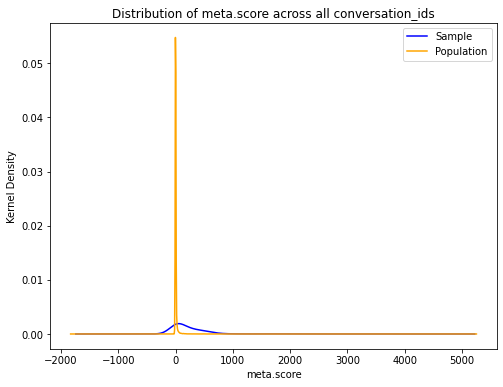

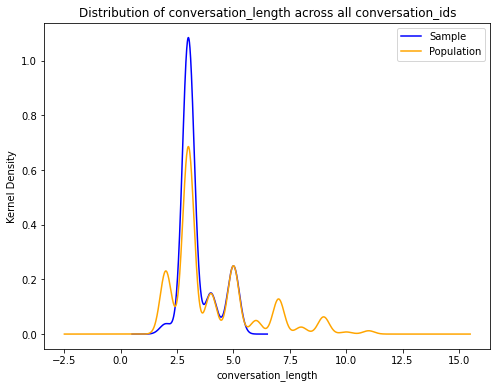

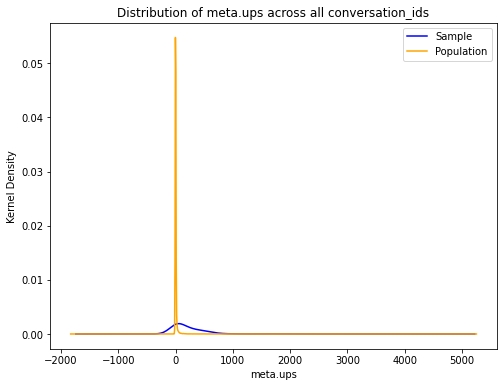

In [197]:
winning_metrics = ['meta.score','conversation_length','meta.ups']
means_winning = calculate_weighted_means(df_winning_conversations, winning_metrics,'psuedo_conv_id')
winning_samples = get_samples(df_winning_conversations, means_winning, 75,'psuedo_conv_id')
validate_samples(winning_samples,df_winning_conversations,winning_metrics,'psuedo_conv_id')

Length of the sample df 394
Number of unique conversations 75
The conversation lengths for each conversation ID in the sample dataset MATCHES with the population dataset.
The concatenated text for each common conversation ID in the sample dataset MATCHES with the population dataset.


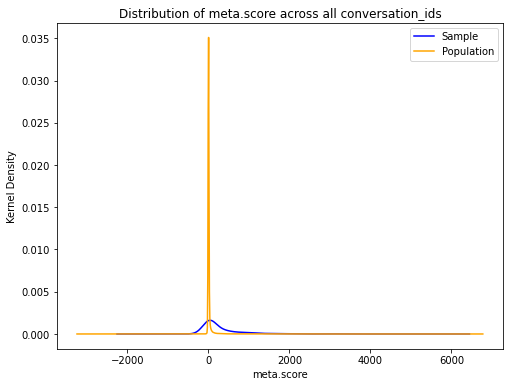

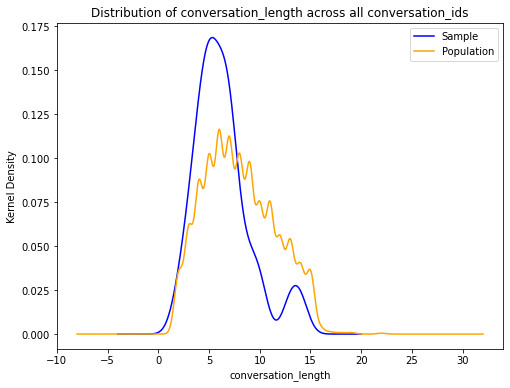

In [199]:
awry_metrics = ['meta.score','conversation_length']
means_awry = calculate_weighted_means(df_awry, awry_metrics,'conversation_id')
awry_samples = get_samples(df_awry, means_awry, 75,'conversation_id')
validate_samples(awry_samples,df_awry,awry_metrics,'conversation_id')

In [ ]:
#convert to csv
awry_samples.to_csv('awry_75_samples.csv')
winning_samples.to_csv('winning_75_samples.csv')

In [200]:
def check_identical_samples(df, weights, num_runs, sample_size, conv_id_col):
    sampled_conversation_ids_list = []

    for _ in range(num_runs):
        awry_samples = get_samples(df, weights, sample_size, conv_id_col)
        sampled_conversation_ids_list.append(awry_samples[conv_id_col].tolist())

    result = all(ids == sampled_conversation_ids_list[0] for ids in sampled_conversation_ids_list)

    if result:
        print("The sampled conversation IDs are the same in all runs.")
    else:
        print("The sampled conversation IDs vary across runs.")

In [201]:
check_identical_samples(df_awry, means_awry,5, 75, 'conversation_id')

The sampled conversation IDs are the same in all runs.


In [203]:
check_identical_samples(df_winning_conversations, means_winning,5, 75, 'psuedo_conv_id')

The sampled conversation IDs are the same in all runs.


### Note
We have to keep the weights constant to ensure that the samples generated are always the same